# Juliaで線型方程式の解の精度保証付き数値計算

$A\in \mathbb{K}^{n\times n}$ を $n$ 次行列、$b\in\mathbb{K}^n$ を $n$ 次元ベクトルとする。ただし $\mathbb{K}=\mathbb{C}$ or $\mathbb{R}$ とする。このとき、線型方程式

$$
Ax=b
$$

の解 $\tilde{x}\in\mathbb{K}$ の精度保証付き数値計算法を紹介する。
行列 $A$ が正則（$\det(A)\neq 0$）ならば、逆行列 $A^{-1}$ が存在し、線型方程式は厳密解がただ一つ存在する。したがって、精度保証付き数値計算で必要なことは、

- 行列 $A$ が正則である
- 厳密解 $\tilde{x}$ の存在する範囲を計算する（誤差評価）

の2つ。

**注意**　数値計算で利用する数値の精度を多数桁に拡張すれば、より高精度な精度保証付き数値計算が可能になるが、今回は倍精度浮動小数点数（Float64）のみを使った精度保証付き数値計算を紹介する。多倍長数値を使った区間演算等は別の機会に。


## 区間ガウスの消去法

区間ガウスの消去法（IG）はいわゆるガウスの消去法を全て区間演算に置き換えた方法であり、"理論上は"解の厳密な包含が得られることになる。しかし、区間ガウスの消去法は、係数行列 $A$ の
次数 $n$ がある程度以上の大きくなると、解の誤差半径が爆発的に大きくなってしまい、適用不可能になるという致命的な欠点がある。これは区間演算による区間幅の増大が原因で、丸め誤差の過大評価によって計算結果が物凄く粗い評価となってしまう。例えば、`IntervalArithmetic.jl`は、区間ガウスの消去法に基づいて線型方程式の求解ができる。

In [72]:
using IntervalArithmetic, StaticArrays, BenchmarkTools
A = [2 2 3; -2 5 1; 5 6 9];
b = A*[2,2,1];　 # Exact solution: (2,2,1)^T

A = map(interval, A);
b = map(interval, b);
# b = SVector{3,Interval}(b);
# A = SMatrix{3,3}(A);
# typeof(b)
# b = SVector{3}(b);
# A = SMatrix{3,3}(A);
# x = A\b
x = A\b
maximum(radius.(x[:]))

3.26405569239796e-14

解の包含の区間幅は約 $10^{-14}$ と十分小さな区間になっていると思われるが、行列のサイズ $n$ が大きくなるにつれて、区間幅が増大し、この方法は破綻する。

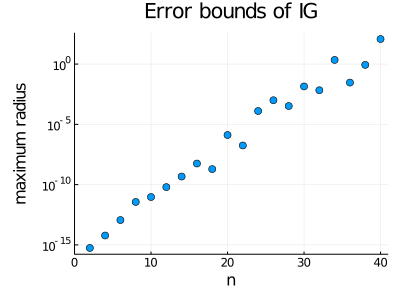

In [73]:
using Plots
index = 2:2:40;
max_rad = zeros(size(index));
i = 1;
for n ∈ index
    A = randn(n,n);
    b = A*ones(n);

    A = map(interval, A)
    b = map(interval, b)

#     A = SMatrix{n,n}(A);
#     b = SVector{n}(b);
    
    x = A\b
    max_rad[i] = maximum(radius.(x[:]));
    i += 1;
end
plot(index, max_rad, yscale=:log10,
    xlabel       ="n",                #X軸のラベル
    ylabel       ="maximum radius",   #Y軸のラベル
    xlims        =(0,41),             #X軸の範囲
    title="Error bounds of IG",       #タイトル
    linewidth    =2,                  #線幅
    seriestype = :scatter,            #点プロットに　
    size         =(400,300),          #プロットのサイズ
    legend = false,                   #凡例消す
)

## BLAS/LAPACKを使う高速精度保証付き数値計算法

行列 $A$ が密行列の場合の精度保証方法を紹介する。この方法の特長は行列計算単位で[区間演算を実行](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/interval_dot-mul.html)することができる。つまり BLAS や LAPACK などの高速で信頼性の高い数値計算ライブラリを利用することができる。そして、区間ガウスの消去法とは違って、次数 $n$ が数千以上のような比較的大規模な行列も計算が成功する。

In [29]:
using LinearAlgebra
n = 5000;
A = randn(n,n);
b = A*ones(n);
@time x = A\b; # Lapack
# x[1:3]
# setprecision(BigFloat,256)
# A = map(BigFloat,A);
# b = A*map(BigFloat,ones(n));
# @time x_dd = A\b; # Native

  0.417036 seconds (6 allocations: 190.811 MiB, 0.94% gc time)


### ノルム評価

次の定理を使用する。

**定理**　行列 $A\in\mathbb{R}^{n\times n}$, $b\in\mathbb{R}^{n}$ に対して、線型方程式 $Ax=b$ の近似解を $\bar{x}$ とする。いま行列 $R\in\mathbb{R}^{n\times n}\approx A^{-1}$が、

$$
\|I-RA\|<1
$$

をみたすとき、

$$
\left\|A^{-1}b-\bar{x}\right\|\le\frac{\|R(b-A \bar{x})\|}{1-\|I-R A\|}
$$

が成り立つ。ただし、$I$ は $n$ 次単位行列とする。


**証明**
$$
\|A^{-1}b - \bar{x}\|=\|(I-(I-RA))^{-1}R(b-A\bar{x})\|\le \frac{\|R(b-A\bar{x})\|}{1-\|I-RA\|}.
$$

ここで、最後の不等式は $\|T\|<1$ となる行列 $T$ に対して、$\|(I-T)^{-1}\|\le 1/(1-\|T\|)$ となる事実（ノイマン級数の上からの評価、$T:=I-RA$）を使っている。<div style="text-align: right;">$\Box$</div>

この定理の十分条件は次の命題から行列 $A$ の正則性を保証している。

**命題**　$\rho(I-RA)\le \|I-RA\|<1$ とする。このとき行列 $R$ と $A$ は正則となる。

**証明** もしも正則でないとすると、$0\neq x\in\mathrm{Ker}(A)$ に対して、$(I-RA)x=x$ となる。すなわち行列 $I-RA$ は少なくとも一つ固有値 $1$ を持つ。しかしこれは $\rho(I-RA)<1$ に矛盾する。<div style="text-align: right;">$\Box$</div>

In [134]:
include("int_num_linalg.jl");
using LinearAlgebra, IntervalArithmetic

function verifylss_naive(A,b)
    x̄ = A\b;
    n = length(x̄);
    R = inv(A);
    #########
    C_mid, C_rad = mm_ufp(R,A);
    C = C_mid .± C_rad;
    α = norm(Matrix{Float64}(I, n, n)-C,Inf)# Interval arithmetic
    #########
    if α < 1
        x̄ = map(Interval,x̄);
        r = A*x̄ - b; # Interval arithmetic
#         err = norm(R*r,Inf)/(1-α); # Interval arithmetic
        err = maximum(abs.(R*r))/(1-α); # Interval arithmetic
    else
        println("verification is failed...")
        err = nan;
    end
    return x = x̄ .± err.hi
end

verifylss_naive (generic function with 1 method)

In [4]:
n = 1000;
A = randn(n,n);
b = A*ones(n);
@time x̄ = A\b;
@time x = verifylss_naive(A,b);
maximum(radius.(x))

  0.005767 seconds (4 allocations: 7.645 MiB)
  1.253901 seconds (12.02 M allocations: 292.094 MiB, 2.91% gc time)


2.2160495660727975e-11

#### 丸めの向きを変更しない精度保証方法

これをもう少し速くしたい。丸めの向きを変更しない次のような評価式を使う。

連立一次方程 $Ax=b$, $A\in\mathbb{F}^{n\times n}$, $b\in\mathbb{F}^{n}$ において、$R\approx A^{-1}$ として、上の定理における $\|I-RA\|_{\infty}$ の上からの評価は最近点丸めのみを用いて、次のように計算できる。

$$
    a_1:=\mathrm{muls}(|A|),\quad a_2:=\mathrm{muld}(|R|, a_1),
$$

$$
    \alpha_1:=\mathrm{muls}(\mathrm{fl}(I-RA)),\quad \alpha_2:=\mathrm{succ}(\mathrm{fl}((n\mathbf{u})\cdot a_2)),\quad \alpha_3:=\mathrm{fl}(n\,\mathbf{S}_{\min}\cdot e_{n}).
$$

ただし、$\mathbf{u}:=2^{-53}$, $\mathbf{S}_{\min}:=2^{-1074}$, $\mathbf{F}_{\min}:=2^{-1022}$, $e_n:=(1,1,\dots,1)\in\mathbb{F}^n$。そして $r\in\mathbb{F}$ に対して、$\mathrm{succ}(r):=\min\{f\in \mathbb{F}:r<f\}$, $\mathrm{ufp}(r):=2^{\lfloor\log_2|r|\rfloor}$として

$$
\operatorname{muls}(A):=\operatorname{succ}(\mathrm{fl}(|A| e_n+(n-1) \mathbf{u} \cdot \operatorname{ufp}(|A| e_n)))\ (\geq|A| e_n)
$$

$$
\operatorname{muld}(A, x):=\operatorname{succ}(\mathrm{fl}(|A x|+(n+2) \mathbf{u} \cdot \operatorname{ufp}(|A \| x|)+\mathbf{F}_{\min} \cdot e))\ (\geq|A x|).
$$

このとき、$\max(\alpha_1)<1$ であれば、

$$
\|I-RA\|_{\infty}\le \left\|\mathrm{fl}\left(\operatorname{succ}\left(\alpha_{1}+\alpha_{2}+\alpha_{3}+\mathbf{u} e_n\right)+3 \mathbf{u} \cdot \operatorname{ufp}\left(\alpha_{1}+\alpha_{2}+\alpha_{3}+\mathbf{u} e_n\right)\right)\right\|_{\infty}
$$

と評価できる。さらに、$\|R(A\bar{x}-b)\|_{\infty}$の上からの評価は次のように得られる。$r:=A\bar{x}-b$として、

$$
r_{\mathrm{mid}}=\mathrm{fl}(r),\quad 
r_{\mathrm{rad}}=\mathrm{fl}((n+3) \mathbf{u} \cdot \operatorname{ufp}(|A \| \bar{x}|+|b|)+\mathbf{F}_{\min} \cdot e_n)
$$

で残差 $r$ の包含が $\mathbf{r}:=\langle r_{\mathrm{mid}}, r_{\mathrm{rad}}\rangle$と得られ、

$$
    |Rr|\le (|Rr_{\mathrm{mid}}| + |R|r_{\mathrm{rad}})
$$

より、

$$
    b_1:=\operatorname{muld}(R, r_{\mathrm{mid}}),\quad b_{2}:=\operatorname{muld}(|R|, r_{\mathrm{rad}})
$$

最終的に、

$$
    \|R(A\bar{x}-b)\|_{\infty}\le \max(\mathrm{succ}(b_1+b_2)).
$$

In [88]:
using IntervalArithmetic
function muls(A)
    u = 2.0^(-53);
    n = size(A,2);
    e = ones(n);
    return succ.(abs.(A)*e+(n-1)*u*ufp.(abs.(A)*e))
end

function muld(A,x)
    u = 2.0^(-53);
    Fmin = 2.0^(-1022);
    n = size(A,2);
    e = ones(n);
    return succ.(abs.(A*x) + (n+2)*u*ufp.(abs.(A)*abs.(x)) + Fmin*e)
end

function verifylss(A,b)
    x̄ = A\b;
    n = length(x̄);
    R = inv(A);
    ######### upper bound of ||I-RA||
    u = 2.0^(-53);
    Smin = 2.0^(-1074);
    Fmin = 2.0^(-1022);
    e = ones(n);
    a₁ = muls(abs.(A));
    a₂ = muld(abs.(R), a₁);
    α₁ = muls(I-R*A);
    α₂ = succ.(n*u*a₂);
    α₃ = n*Fmin*e;
    if maximum(α₁) < 1
        α = norm(succ.(α₁ + α₂ + α₃ + u*e) + 3*u*ufp.(α₁ + α₂ + α₃ + u*e),Inf);
    else
        println("α₁ is less than 1")
        err = nan;
    end
    if α < 1
        ######### upper bound of ||Ax̄-b||
        rmid = A*x̄ - b;
        rrad = (n+3)*u*ufp.(abs.(A)*abs.(x̄) + abs.(b)) + Fmin*e;
        b₁ = muld(R,rmid);
        b₂ = muld(abs.(R),rrad);
        r_inf_norm = maximum(succ.(b₁ + b₂));
        #########
        err = r_inf_norm/(1-map(Interval,α));
    else
        println("verification is failed...")
        err = nan;
    end
    return x = x̄ .± err.hi
end

verifylss (generic function with 1 method)

In [124]:
n = 1000;
A = randn(n,n);
b = A*ones(n);
@time x̄ = A\b;
@time x₁ = verifylss_naive(A,b);
@show maximum(radius.(x₁));
@time x₂ = verifylss(A,b);
@show maximum(radius.(x₂));

  0.006610 seconds (4 allocations: 7.645 MiB)
  1.089205 seconds (42 allocations: 108.622 MiB)
maximum(radius.(x₁)) = 1.340483279932414e-11
  0.053520 seconds (110 allocations: 116.717 MiB)
maximum(radius.(x₂)) = 3.1746512085817358e-9


### 成分毎評価

**定理（山本の定理）** $A$, $R\in\mathbb{R}^{n\times n}$, $b$, $\bar{x}\in\mathbb{R}^n$, $G:=I-RA$ とする。このとき、$\|G\|_{\infty}<1$ ならば、行列 $A$ は正則であり、次の評価が成り立つ。

$$
|A^{-1}b-\bar{x}|\le |R(b-A\bar{x})| + \frac{\|R(b-A\bar{x})\|_{\infty}}{1-\|G\|_{\infty}}|G|e_n,
$$

ここで、$e_n = (1,1,\dots,1)\in\mathbb{R}^n$で、行列・ベクトルの絶対値は成分毎に絶対値を取るものとし、不等式は成分毎に不等式が成立しているものとする。

**証明** $A^{-1}=(RA)^{-1}R$ ($R$ は正則行列)であり、$\|G\|_{\infty}<1$ より、

$$
(RA)^{-1}=(I-G)^{-1} = I + G + G^2 + \dots = I + G(I-G)^{-1}
$$

となる。任意の $v\in\mathbb{R}^n$ に対して、$|v|\le\|v\|_{\infty} e_n$ であることに注意すると、

\begin{align}
|A^{-1}b-\bar{x}| &= |(RA)^{-1}R(b-A\bar{x})|\\
&= |(I+G(I-G)^{-1})R(b-A\bar{x})|\\
&\le |R(b-A\bar{x})|+|G||(I-G)^{-1}R(b-A\bar{x})|\\
&\le |R(b-A\bar{x})|+\|(I-G)^{-1}\|_{\infty}\|R(b-A\bar{x})\|_{\infty}|G|e_n
\end{align}

となり、$\|(I-G)^{-1}\|_{\infty}\le 1/(1-\|G\|_{\infty})$ を用いると上記の評価式を得る。
<div style="text-align: right;">$\Box$</div>

In [125]:
function verifylss_ew(A,b) # verify the solution element-wisely
    x̄ = A\b;
    n = length(x̄);
    R = inv(A);
    #########
    C_mid, C_rad = mm_ufp(R,A);
    C = C_mid .± C_rad;
    G = Matrix{Float64}(I, n, n) - C;
    α = norm(G,Inf)# Interval arithmetic
    #########
    if α < 1
        x̄ = map(Interval,x̄);
        r = A*x̄ - b; # Interval arithmetic
        Rr = R*r;
        err = abs.(Rr) + supremum(norm(Rr,Inf)/(1-α))*(abs.(G)*ones(n)); # Interval arithmetic
    else
        println("verification is failed...")
        err = nan;
    end
    return x = x̄ .± supremum.(err)
end

# function verifylss(A,b)
#     x̄ = A\b;
#     n = length(x̄);
#     R = inv(A);
#     ######### upper bound of ||I-RA||
#     u = 2.0^(-53);
#     Smin = 2.0^(-1074);
#     Fmin = 2.0^(-1022);
#     e = ones(n);
#     a₁ = muls(abs.(A));
#     a₂ = muld(abs.(R), a₁);
#     α₁ = muls(I-R*A);
#     α₂ = succ.(n*u*a₂);
#     α₃ = n*Fmin*e;
#     if maximum(α₁) < 1
#         α = norm(succ.(α₁ + α₂ + α₃ + u*e) + 3*u*ufp.(α₁ + α₂ + α₃ + u*e),Inf);
#     else
#         println("α₁ is less than 1")
#         err = nan;
#     end
#     if α < 1
#         ######### upper bound of ||Ax̄-b||
#         rmid = A*x̄ - b;
#         rrad = (n+3)*u*ufp.(abs.(A)*abs.(x̄) + abs.(b)) + Fmin*e;
#         b₁ = muld(R,rmid);
#         b₂ = muld(abs.(R),rrad);
#         r_inf_norm = maximum(succ.(b₁ + b₂));
#         #########
#         err = r_inf_norm/(1-map(Interval,α));
#     else
#         println("verification is failed...")
#         err = nan;
#     end
#     return x = x̄ .± err.hi
# end

In [135]:
@time x₁ = verifylss_naive(A,b);
@show mean(radius.(x₁));
# @time x₂ = verifylss(A,b);
# @show maximum(radius.(x₂));
@time x₃ = verifylss_ew(A,b);
@show mean(radius.(x₃));
# a = map(Interval,ones(3))
# supremum.(a+a)

  1.186421 seconds (251.75 k allocations: 120.263 MiB, 3.27% gc time)
mean(radius.(x₁)) = 7.475955976499194e-11
  1.008312 seconds (74.61 k allocations: 127.105 MiB)
mean(radius.(x₃)) = 2.8624647874231358e-11


In [122]:
a = map(Interval,rand(100));
@show norm(a,Inf)
@show maximum(abs.(a))

norm(a, Inf) = [0.999492, 0.999493]
maximum(abs.(a)) = [0.999492, 0.999493]


[0.999492, 0.999493]